# TNBC Drug Response Prediction Model (failed attempt)


In [ ]:
# Imports
import pandas as pd
import numpy as np
import gseapy as gp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from boruta import BorutaPy
from scipy import stats
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import warnings
import os

os.environ['MallocStackLogging'] = '0'
warnings.filterwarnings('ignore')

### Data and TNBC Cell Line Selection

 Load drug response data, gene expression, mutations, and CNV data and filter on TNBC cell lines that have both drug response and gene expression data available. 


In [5]:
# Load data
data_path = 'Datasets/Cytoxicity Model/'
cell_drug_data = pd.read_csv(f'{data_path}GDSC2 Dose Response Oct 27.csv')
gene_expression = pd.read_csv(f'{data_path}E-MTAB-3610 Matrix.csv', index_col=0)
mutations = pd.read_csv(f'{data_path}mutations_all_20250318.csv')
cnv = pd.read_csv(f'{data_path}WES_pureCN_CNV_genes_20250207.csv')

# TNBC cell lines
tnbc_markers = ['MDA-MB-231', 'MDA-MB-468', 'BT-549', 'HCC1806', 
                'HCC1937', 'HCC38', 'HCC70', 'HCC1143', 'BT-20',
                'MDA-MB-157', 'MDA-MB-436', 'MDA-MB-453', 'Hs578T',
                'SUM149PT', 'SUM159PT', 'CAL-51', 'CAL-120', 'CAL-148',
                'DU4475', 'HDQ-P1']

tnbc_drug_data = cell_drug_data[cell_drug_data['CELL_LINE_NAME'].isin(tnbc_markers)]

# Find cell lines with both drug response and gene expression
ge_columns = gene_expression.columns.tolist()
tnbc_with_both = []
for line in tnbc_markers:
    line_dot = line.replace('-', '.')
    has_drug = line in tnbc_drug_data['CELL_LINE_NAME'].values
    has_ge = line_dot in ge_columns or line in ge_columns
    if has_drug and has_ge:
        tnbc_with_both.append(line)

tnbc_combined_data = tnbc_drug_data[tnbc_drug_data['CELL_LINE_NAME'].isin(tnbc_with_both)].copy()
tnbc_ge_columns = [line.replace('-', '.') for line in tnbc_with_both]
tnbc_gene_expression = gene_expression[tnbc_ge_columns].copy()
tnbc_gene_expression.columns = tnbc_with_both



Loaded 12 TNBC cell lines, 3286 drug responses, 19,440 genes


### Data Preprocessing

Convert IC50 and AUC values to numeric format and remove missing values.

In [6]:
# Numeric cleanup
tnbc_combined_data['LN_IC50'] = tnbc_combined_data['LN_IC50'].str.replace(',', '.').astype(float)
tnbc_combined_data['AUC'] = tnbc_combined_data['AUC'].str.replace(',', '.').astype(float)
tnbc_combined_data = tnbc_combined_data.dropna(subset=['LN_IC50'])

### Gene Expression Data Preparation

Standardize gene names (uppercase) and take the average of two duplicate gene entries if present.

In [7]:
# Prepare expression data
tnbc_gene_expression.index = tnbc_gene_expression.index.str.upper().str.strip()

# Handle duplicates
duplicates = tnbc_gene_expression.index.duplicated(keep=False)
if duplicates.any():
    tnbc_gene_expression = tnbc_gene_expression.groupby(tnbc_gene_expression.index).mean()


### Compute Pathway Activity Scores (ssGSEA)

Run single-sample Gene Set Enrichment Analysis (ssGSEA) using Reactome pathways to calculate pathway enrichment scores for each cell line.


In [8]:
# Compute pathway activity with ssGSEA
gene_sets = 'Reactome_2022'
ssgsea_gene_set = gene_sets

try:
    ssgsea_results = gp.ssgsea(
        data=tnbc_gene_expression,
        gene_sets=gene_sets,
        outdir=None,
        sample_norm_method='rank',
        no_plot=True,
        processes=4,
        min_size=15,
        max_size=500,
        permutation_num=0
    )
except Exception:
    ssgsea_gene_set = 'MSigDB_Hallmark_2020'
    ssgsea_results = gp.ssgsea(
        data=tnbc_gene_expression,
        gene_sets=ssgsea_gene_set,
        outdir=None,
        no_plot=True,
        processes=1,
        min_size=5,
        max_size=500
    )


Running ssGSEA...
Completed with Reactome_2022


### Normalize pathway scores

Transpose pathway scores so they have the cell lines as rows, add a PATH_ prefix to the names of the pathways for  extra clarity and use z-score normalization to set the mean to 0 and standard deviation to 1 for each pathway .


In [9]:
# Process pathway scores
pathway_scores = ssgsea_results.res2d.pivot(index='Term', columns='Name', values='ES')
pathway_scores_T = pathway_scores.T
pathway_scores_T = pathway_scores_T.reset_index()
pathway_scores_T = pathway_scores_T.rename(columns={'Name': 'CELL_LINE_NAME'})

pathway_cols = [col for col in pathway_scores_T.columns if col != 'CELL_LINE_NAME']
pathway_scores_T = pathway_scores_T.rename(columns={col: f'PATH_{col}' for col in pathway_cols})

# Z-score normalization
pathway_feature_cols = [col for col in pathway_scores_T.columns if col.startswith('PATH_')]
for col in pathway_feature_cols:
    mean_val = pathway_scores_T[col].mean()
    std_val = pathway_scores_T[col].std()
    if std_val > 0:
        pathway_scores_T[col] = (pathway_scores_T[col] - mean_val) / std_val
    else:
        pathway_scores_T[col] = 0




Processed 1178 pathway features


### Merge Pathway Features with Drug Response Data

Join pathway enrichment scores with drug response data (IC50) for every cell line and remove pathways with zero variance.

In [10]:
# Merge pathways with drug response
pathway_scores_T['CELL_LINE_NAME'] = pathway_scores_T['CELL_LINE_NAME'].str.upper()
tnbc_combined_data['CELL_LINE_NAME_UPPER'] = tnbc_combined_data['CELL_LINE_NAME'].str.upper()

merged_data = tnbc_combined_data.merge(
    pathway_scores_T, 
    left_on='CELL_LINE_NAME_UPPER', 
    right_on='CELL_LINE_NAME', 
    how='inner',
    suffixes=('', '_pathway')
)

if 'CELL_LINE_NAME_pathway' in merged_data.columns:
    merged_data = merged_data.drop(columns=['CELL_LINE_NAME_pathway'])
if 'CELL_LINE_NAME_UPPER' in merged_data.columns:
    merged_data = merged_data.drop(columns=['CELL_LINE_NAME_UPPER'])

# Remove constant pathways
pathway_cols = [col for col in merged_data.columns if col.startswith('PATH_')]
pathway_data = merged_data[pathway_cols]
variances = pathway_data.var()
constant_pathways = variances[variances == 0].index.tolist()
pathway_cols_filtered = [col for col in pathway_cols if col not in constant_pathways]




Merged data: 3286 samples, 1178 pathway features


### Feature Selection Strategy

Use all non-constant pathway features this part is here because this used to be where I applied Boruta but that filtered everything down to a single pathway (at which point I realized this most likely wasn't going to work)


In [11]:
# Using all pathway features (no selection)
selected_pathways = pathway_cols_filtered


### Add Drug Mechanism and Genomic Alterations

Enrich the dataset with target proteins, target pathways, top 100 mutated genes, driver mutation counts, top 50 copy number altered genes, etc. 


In [12]:
# Add drug features
drug_compounds = pd.read_csv(f'{data_path}Screened Compounds v8.5.csv')
merged_data = merged_data.merge(
    drug_compounds[['DRUG_NAME', 'TARGET', 'TARGET_PATHWAY']],
    on='DRUG_NAME', how='left'
)
target_enc = pd.get_dummies(merged_data['TARGET'], prefix='TARGET', dummy_na=True)
tgtpath_enc = pd.get_dummies(merged_data['TARGET_PATHWAY'], prefix='TGTPATH', dummy_na=True)
merged_data = pd.concat([merged_data, target_enc, tgtpath_enc], axis=1)

# Add mutation features
top_genes = mutations['gene_symbol'].value_counts().head(100).index.tolist()
driver_muts = mutations[mutations['cancer_driver'] == 't']

mut_list = []
for cell in tnbc_with_both:
    cm = mutations[mutations['model_name'] == cell]
    md = {'CELL_LINE_NAME': cell}
    for g in top_genes:
        md[f'MUT_{g}'] = 1 if g in cm['gene_symbol'].values else 0
    md['DRIVER_MUT_CNT'] = len(driver_muts[driver_muts['model_name'] == cell])
    md['TOTAL_MUT_CNT'] = len(cm)
    mut_list.append(md)

mut_df = pd.DataFrame(mut_list)
merged_data = merged_data.merge(mut_df, on='CELL_LINE_NAME', how='left')

# Add CNV features
top_cnv = cnv[cnv['cn_category'] != 'Neutral']['symbol'].value_counts().head(50).index.tolist()

cnv_list = []
for cell in tnbc_with_both:
    cc = cnv[cnv['model_name'] == cell]
    cd = {'CELL_LINE_NAME': cell}
    for g in top_cnv:
        gc = cc[cc['symbol'] == g]
        if len(gc) > 0:
            cn = gc['total_copy_number'].values[0]
            cd[f'CNV_{g}'] = cn
            cd[f'AMP_{g}'] = 1 if cn > 2.5 else 0
            cd[f'DEL_{g}'] = 1 if cn < 1.5 else 0
        else:
            cd[f'CNV_{g}'] = 2.0
            cd[f'AMP_{g}'] = 0
            cd[f'DEL_{g}'] = 0
    cd['AMP_CNT'] = len(cc[cc['cn_category'] == 'Amplification'])
    cd['DEL_CNT'] = len(cc[cc['cn_category'] == 'Deletion'])
    cnv_list.append(cd)

cnv_df = pd.DataFrame(cnv_list)
merged_data = merged_data.merge(cnv_df, on='CELL_LINE_NAME', how='left')

# Create interaction features
drug_targets = [col for col in merged_data.columns if col.startswith('TARGET_') and col not in ['TARGET', 'TARGET_PATHWAY']]
mutations_cols = [col for col in merged_data.columns if col.startswith('MUT_')]

top_targets = ['TARGET_EGFR', 'TARGET_BRAF', 'TARGET_PIK3CA', 'TARGET_MTOR', 
               'TARGET_CDK4', 'TARGET_PARP', 'TARGET_MEK', 'TARGET_AKT1']
top_targets = [t for t in top_targets if t in drug_targets]

key_mutations = ['MUT_TP53', 'MUT_PIK3CA', 'MUT_PTEN', 'MUT_BRCA1', 'MUT_BRCA2']
key_mutations = [m for m in key_mutations if m in mutations_cols]

interaction_features = pd.DataFrame(index=merged_data.index)

# Drug target x mutation interactions
for target in top_targets[:5]:
    for mut in key_mutations[:5]:
        int_name = f'INT_{target}x{mut}'
        interaction_features[int_name] = merged_data[target] * merged_data[mut]

# Drug target x pathway interactions
pathway_vars = merged_data[selected_pathways].var().sort_values(ascending=False)
top_pathways = pathway_vars.head(20).index.tolist()

for target in top_targets[:3]:
    for pathway in top_pathways[:5]:
        int_name = f'INT_{target}x{pathway[-20:]}'
        interaction_features[int_name] = merged_data[target] * merged_data[pathway]

merged_data = pd.concat([merged_data, interaction_features], axis=1)


Added drug, mutation, and CNV features - total columns: 1665
Created 15 interaction features


In [13]:
# Save model-ready dataset
drug_target_cols = [col for col in merged_data.columns if col.startswith('TARGET_') and col not in ['TARGET', 'TARGET_PATHWAY']]
drug_pathway_cols = [col for col in merged_data.columns if col.startswith('TGTPATH_')]
mutation_cols = [col for col in merged_data.columns if col.startswith('MUT_') or col.endswith('_MUT_CNT')]
cnv_cols = [col for col in merged_data.columns if col.startswith('CNV_') or col.startswith('AMP_') or col.startswith('DEL_') or col.endswith('_CNT')]
interaction_cols = [col for col in merged_data.columns if col.startswith('INT_')]

all_feature_cols = selected_pathways + drug_target_cols + drug_pathway_cols + mutation_cols + cnv_cols + interaction_cols
final_data = merged_data[['CELL_LINE_NAME', 'DRUG_NAME', 'LN_IC50', 'AUC'] + all_feature_cols].copy()

final_data.to_csv('tnbc_pathway_features.csv', index=False)
with open('selected_pathways.txt', 'w') as f:
    for pathway in selected_pathways:
        f.write(f"{pathway.replace('PATH_', '')}\n")





### Prepare for Modeling

Extract pathway features (X) and LN_IC50 target (y), then split into 80% training and 20% test sets.


In [16]:
# Prepare data for modeling
X = final_data[selected_pathways].values
y = final_data['LN_IC50'].values
X = X.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = {}


### Model

RF, XGB, and Deep Learning


In [17]:
# Random Forest model
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)

results['Random Forest'] = {
    'train_rmse': train_rmse_rf,
    'test_rmse': test_rmse_rf,
    'train_r2': train_r2_rf,
    'test_r2': test_r2_rf,
    'train_mae': train_mae_rf,
    'test_mae': test_mae_rf
}

print(f"RF - Train RMSE: {train_rmse_rf:.4f}, R²: {train_r2_rf:.4f} | Test RMSE: {test_rmse_rf:.4f}, R²: {test_r2_rf:.4f}")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kfold, 
                            scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)
print(f"CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")

feature_importance = pd.DataFrame({
    'pathway': [p.replace('PATH_', '') for p in selected_pathways],
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)


Training Random Forest...


python(69882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


RF - Train RMSE: 2.6673, R²: 0.0589 | Test RMSE: 2.8351, R²: 0.0210


python(69885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


CV RMSE: 2.6773 (+/- 0.0297)


In [18]:
# XGBoost model
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

results['XGBoost'] = {
    'train_rmse': train_rmse_xgb,
    'test_rmse': test_rmse_xgb,
    'train_r2': train_r2_xgb,
    'test_r2': test_r2_xgb,
    'train_mae': train_mae_xgb,
    'test_mae': test_mae_xgb
}

print(f"XGB - Train RMSE: {train_rmse_xgb:.4f}, R²: {train_r2_xgb:.4f} | Test RMSE: {test_rmse_xgb:.4f}, R²: {test_r2_xgb:.4f}")

cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=kfold, 
                                scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_xgb = np.sqrt(-cv_scores_xgb)
print(f"CV RMSE: {cv_rmse_xgb.mean():.4f} (+/- {cv_rmse_xgb.std():.4f})")

feature_importance_xgb = pd.DataFrame({
    'pathway': [p.replace('PATH_', '') for p in selected_pathways],
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)


Training XGBoost...
XGB - Train RMSE: 2.6674, R²: 0.0589 | Test RMSE: 2.8347, R²: 0.0213
CV RMSE: 2.6773 (+/- 0.0297)


In [ ]:
# this one is fully AI generated so I cannot defind all the modelling choices because I already saw how bad the performance of above was so it was like a last check to see if it would work or if i should just start over. 
tf.random.set_seed(42)
np.random.seed(42)

dl_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

dl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

history = dl_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

y_train_pred_dl = dl_model.predict(X_train, verbose=0).flatten()
y_test_pred_dl = dl_model.predict(X_test, verbose=0).flatten()

train_rmse_dl = np.sqrt(mean_squared_error(y_train, y_train_pred_dl))
test_rmse_dl = np.sqrt(mean_squared_error(y_test, y_test_pred_dl))
train_r2_dl = r2_score(y_train, y_train_pred_dl)
test_r2_dl = r2_score(y_test, y_test_pred_dl)
train_mae_dl = mean_absolute_error(y_train, y_train_pred_dl)
test_mae_dl = mean_absolute_error(y_test, y_test_pred_dl)

results['Deep Learning'] = {
    'train_rmse': train_rmse_dl,
    'test_rmse': test_rmse_dl,
    'train_r2': train_r2_dl,
    'test_r2': test_r2_dl,
    'train_mae': train_mae_dl,
    'test_mae': test_mae_dl
}
print(f"DL - Train RMSE: {train_rmse_dl:.4f}, R²: {train_r2_dl:.4f} | Test RMSE: {test_rmse_dl:.4f}, R²: {test_r2_dl:.4f}")



DL - Train RMSE: 2.7493, R²: 0.0002 | Test RMSE: 2.8544, R²: 0.0076




### Results


Model Comparison:
               train_rmse  test_rmse  train_r2  test_r2  train_mae  test_mae
Random Forest      2.6673     2.8351    0.0589   0.0210     1.9967    2.1121
XGBoost            2.6674     2.8347    0.0589   0.0213     1.9981    2.1142
Deep Learning      2.7493     2.8544    0.0002   0.0076     2.1521    2.1999

Best model: XGBoost (R²: 0.0213)


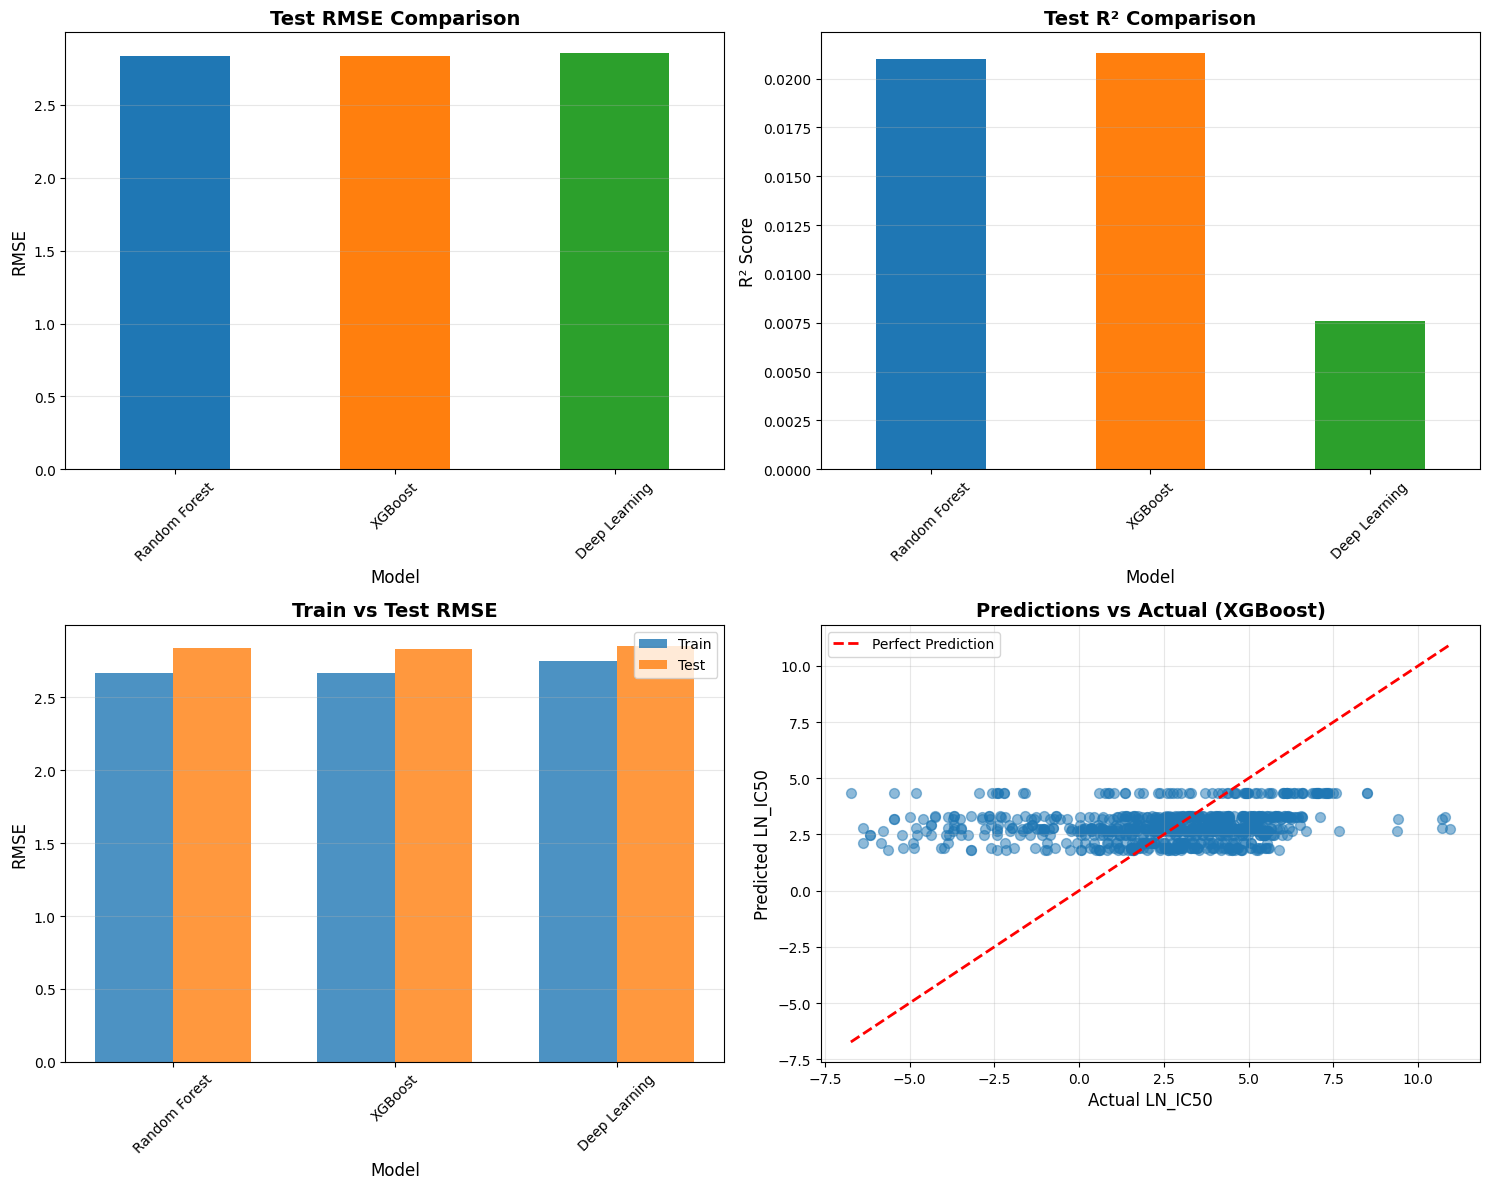

In [20]:
# Model comparison
comparison_df = pd.DataFrame(results).T.round(4)
print("\nModel Comparison:")
print(comparison_df)

best_model = comparison_df['test_r2'].idxmax()
print(f"\nBest model: {best_model} (R²: {comparison_df.loc[best_model, 'test_r2']:.4f})")

comparison_df.to_csv('model_comparison_results.csv')

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = axes[0, 0]
comparison_df['test_rmse'].plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

ax2 = axes[0, 1]
comparison_df['test_r2'].plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('Test R² Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

ax3 = axes[1, 0]
x = np.arange(len(comparison_df))
width = 0.35
ax3.bar(x - width/2, comparison_df['train_rmse'], width, label='Train', alpha=0.8)
ax3.bar(x + width/2, comparison_df['test_rmse'], width, label='Test', alpha=0.8)
ax3.set_title('Train vs Test RMSE', fontsize=14, fontweight='bold')
ax3.set_ylabel('RMSE', fontsize=12)
ax3.set_xlabel('Model', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(comparison_df.index, rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 1]
if best_model == 'Random Forest':
    y_pred_best = y_test_pred_rf
elif best_model == 'XGBoost':
    y_pred_best = y_test_pred_xgb
else:
    y_pred_best = y_test_pred_dl

ax4.scatter(y_test, y_pred_best, alpha=0.5, s=50)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax4.set_title(f'Predictions vs Actual ({best_model})', fontsize=14, fontweight='bold')
ax4.set_xlabel('Actual LN_IC50', fontsize=12)
ax4.set_ylabel('Predicted LN_IC50', fontsize=12)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
